# **Initial Load**

Authenticate with Google Drive and read in our dataset.

In [1]:
# Install any required packages.
!pip install -U -q PyDrive

In [2]:
# Import any required libraries.
from google.colab import auth
from patsy import dmatrices
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# Authenticate with Google Drive.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Download our dataset from Google Drive.
downloaded_file = drive.CreateFile({ 'id': '14RMV7CRXwwCt_9iLHenyQrB9GC5gYwul' })
downloaded_file.GetContentFile('ChicagoCrimeRecords.csv')
chicago_crime_records = pd.read_csv('ChicagoCrimeRecords.csv')

In [5]:
# Clear the downloaded file and all other variables from memory, once we've converted it to a data frame.
del downloaded_file, drive, gauth

# **Data Preparation**
Trim our dataset and split it out into training and test sets.

In [6]:
# Drop any NANs before we begin.
chicago_crime_records.dropna(inplace = True)

In [14]:
# Remove any columns that we are confident will not be of any use to our model.
chicago_crime_records.drop(
    columns = [
        'Block',
        'Case Number',
        'Date',
        'Description',
        'ID',
        'Latitude',
        'Location',
        'Longitude',
        'Updated On'],
    axis = 1,
    inplace = True,
    errors = 'ignore')

In [15]:
# Encode the 'Arrest', 'Domestic', 'FBI Code', 'IUCR' and 'Location Description' columns.
chicago_crime_records['Arrest'] = chicago_crime_records['Arrest'].astype(int)

chicago_crime_records['Domestic'] = chicago_crime_records['Domestic'].astype(int)

chicago_crime_records['FBI Code'] = chicago_crime_records['FBI Code'].astype('category')
chicago_crime_records['FBI Code'] = chicago_crime_records['FBI Code'].cat.codes

chicago_crime_records['IUCR'] = chicago_crime_records['IUCR'].astype('category')
chicago_crime_records['IUCR'] = chicago_crime_records['IUCR'].cat.codes

chicago_crime_records['Location Description'] = chicago_crime_records['Location Description'].astype('category')
chicago_crime_records['Location Description'] = chicago_crime_records['Location Description'].cat.codes

In [ ]:
# Take a look at our dataset, once we've encoded all of our features.
chicago_crime_records.head()

In [17]:
# Split out our data into training and test sets.
X = chicago_crime_records.drop(columns = 'Primary Type')
Y = chicago_crime_records['Primary Type']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

In [19]:
# Clear the original data frame and other assorted variables from memory, now that we no longer need it.
del chicago_crime_records, X, Y

# **Model Tuning**
Carry out some parametric tuning before we train our Random Forest classifier.

In [ ]:
# Carry out some hyperparameter tuning.
parameters = {
    'n_estimators': [25, 50, 75],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 7, 9],
    'criterion': ['gini', 'entropy']
}

tuned_model = GridSearchCV(RandomForestClassifier(), parameters).fit(x_train.sample(n = 50000), y_train.sample(n = 50000))

In [25]:
# Take a look at the resultant parameters.
tuned_model.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 50}

# **Model Training**
Train a Random Forest classifier.

In [26]:
# Train a Random Forest classifier.
classifier = RandomForestClassifier(
    bootstrap = True,
    class_weight = None,
    criterion = 'entropy',
    max_depth = 7,
    max_features = 'auto',
    max_leaf_nodes = None,
    min_impurity_decrease = 0.0,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_weight_fraction_leaf = 0.0,
    n_estimators = 50,
    n_jobs = 1,
    oob_score = False,
    random_state = 41,
    verbose = 0,
    warm_start = False)

classifier.fit(x_train, y_train)
classifier_predictions = classifier.predict(x_test)

# **Model Evalution**
Evaluate the accuracy of our Random Forest classifier.

In [27]:
# Evaluate the importance of the features in our model.
feature_importance = pd.Series(
    classifier.feature_importances_,
    index = x_train.columns).sort_values(ascending = False)

feature_importance

IUCR                    0.458518
FBI Code                0.401447
Arrest                  0.066364
Location Description    0.031539
Domestic                0.029581
Year                    0.003725
Ward                    0.002959
Community Area          0.001499
Y Coordinate            0.001320
Beat                    0.001286
X Coordinate            0.000977
District                0.000783
dtype: float64

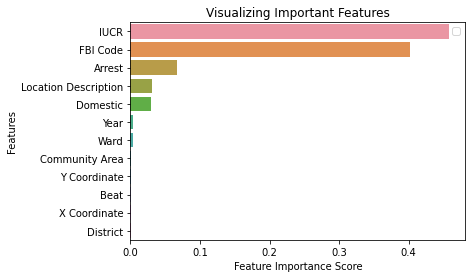

In [28]:
# Evaluate the importance of the features in our model.
sns.barplot(x = feature_importance, y = feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features')
plt.legend()
plt.show()

In [29]:
# Evaluate the accuracy of our model.
print("Accuracy:", metrics.accuracy_score(y_test, classifier_predictions))

Accuracy: 0.9785357155816887
